# IMPORTS AND DATA

In [34]:
from fireTS.models import NARX, DirectAutoRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.svm import SVR, LinearSVR
from sklearn.model_selection import train_test_split
from sklearn.linear_model import SGDRegressor
from keras.preprocessing.sequence import TimeseriesGenerator
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

In [228]:
import pandas as pd
import glob
import os
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow 
#import autokeras as ak
import scipy.io
from xgboost import XGBRegressor
import pandas as pd
import numpy as np
import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN

In [327]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Results2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y=df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

In [321]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt"))))
X_train=df.drop(columns=['SOC_tot'])
y_train = df.SOC_tot

df_test = pd.read_csv('../raw_data/CSVs/hwy.csv')
X_test=df_test.drop(columns=['SOC_tot'])
y_test = df_test.SOC_tot

# NARX

In [330]:
mdl1 = NARX(
    LinearSVR(),
    auto_order=6,
    exog_order=[1,1,1,1],
    )

mdl1.fit(X_train, y_train)
ypred1 = mdl1.predict(X_test, y_test, step=3)

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/sklearn/svm/_base.py:946: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


In [331]:
len1 = len(ypred1[11:])


X_len1 = np.linspace(0,len1,len1)
print(mean_absolute_error(ypred1[11:],y_test[11:]))
print(mean_squared_error(ypred1[11:],y_test[11:], squared=False))

0.10035587074359405
1.6496690692522888


In [235]:
ypred_test = mdl1.forecast(X_test, y_test, step=10)

In [ ]:
mdl2 = DirectAutoRegressor(
    LinearRegression(),
    auto_order=6,
    exog_order=[1, 1,1,1],
    pred_step=3)

mdl2.fit(X_train, y_train)
ypred2 = mdl2.predict(X_test, y_test)

In [ ]:
mdl3 = NARX(
    SVR(),
    auto_order=1,
    exog_order=[1, 1,1,1]
    )

mdl3.fit(X_train, y_train)
ypred3 = mdl3.predict(X_test, y_test)

In [ ]:
print(mdl1.score(X_test,y_test, method='mse'))
print(mdl2.score(X_test,y_test, method='mse'))
#print(mdl3.score(X_test,y_test, method='mse'))

# PLOTS

0.050529497933736144
0.060030554992211084


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

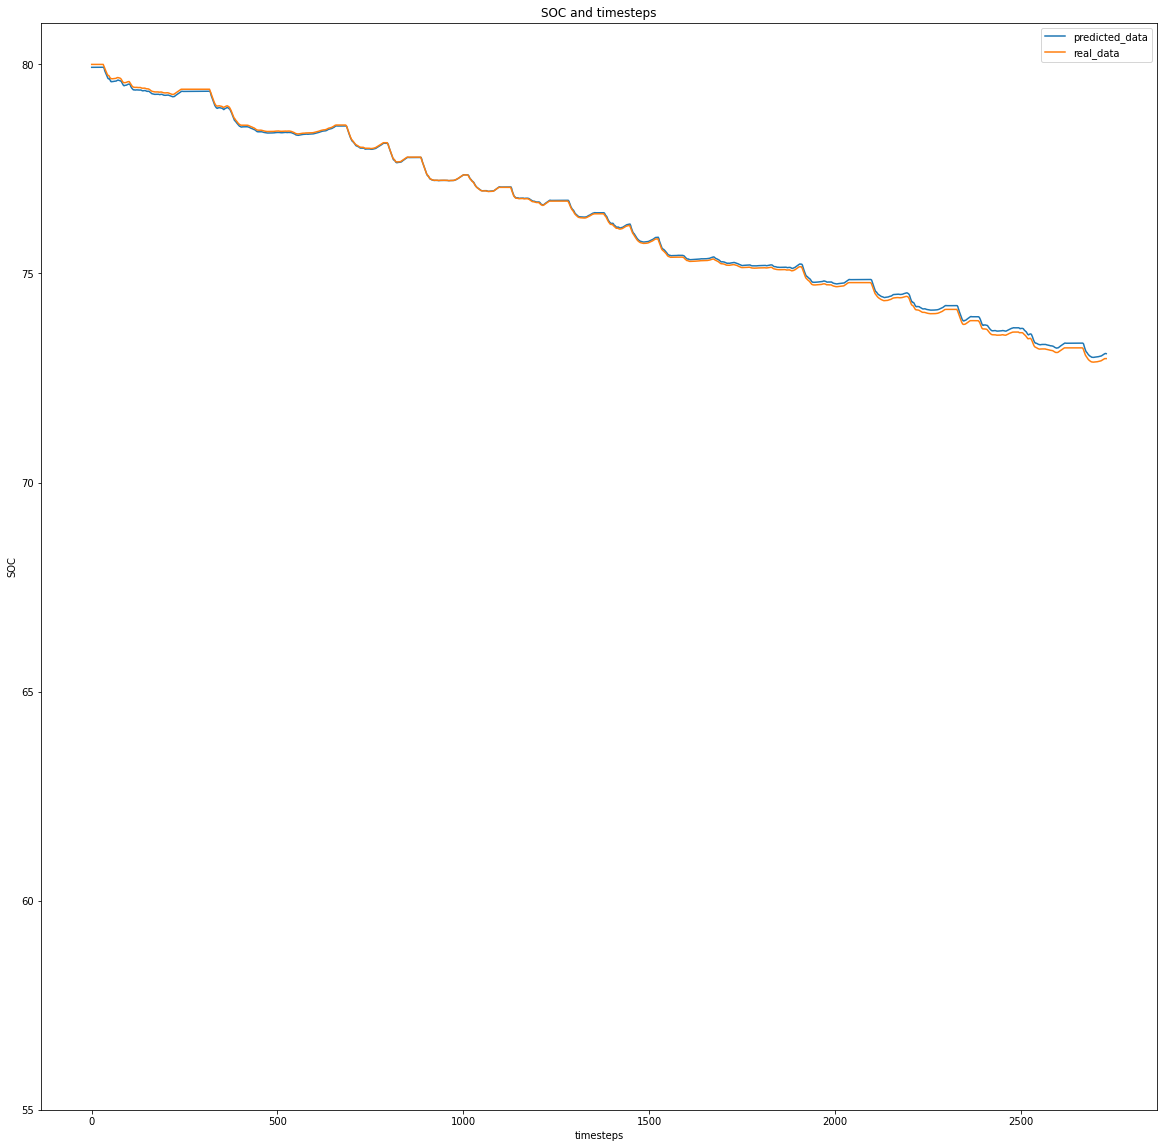

In [225]:
len1 = len(ypred1[11:])


X_len1 = np.linspace(0,len1,len1)

print(mean_absolute_error(ypred1[11:],y_test[11:]))
print(mean_squared_error(ypred1[11:],y_test[11:], squared=False))

plt.figure(figsize=(20,20))
plt.plot(X_len1,ypred1[11:], label='predicted_data')
plt.plot(X_len1,y_test[11:], label='real_data')
plt.title('SOC and timesteps')
plt.xlabel('timesteps')
plt.ylabel('SOC')
plt.legend()
plt.ylim(55,81)
plt.show()

In [ ]:
len1 = len(ypred2[10:])


X_len1 = np.linspace(0,len1,len1)
print(mean_absolute_error(ypred2[10:],y_test[10:]))
print(mean_squared_error(ypred2[10:],y_test[10:], squared=False))

plt.figure(figsize=(10,10))
plt.plot(X_len1,ypred2[10:], label='predicted_data')
plt.plot(X_len1,y_test[10:], label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.ylim(70,82)
plt.show()

In [ ]:
len1 = len(ypred3[10:])


X_len1 = np.linspace(0,len1,len1)
print(mean_absolute_error(ypred3[10:],y_test[10:]))
print(mean_squared_error(ypred3[10:],y_test[10:], squared=False))

plt.figure(figsize=(20,20))
plt.plot(X_len1,ypred3[10:], label='predicted_data')
plt.plot(X_len1,y_test[10:], label='real_data')
plt.title('percentage of battery over discharge cycle')
plt.xlabel('datapoints')
plt.ylabel('percentage of battery')
plt.legend()
plt.ylim(77,82)
plt.show()

# CNN-LSTM

In [365]:
def cnn_lstm():

    # train, test = train_test_split(df, shuffle=True, test_size=0.2)
    epochs=10
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/Results2/*.txt")))) # read data 
    y_col='SOC_tot' # define y variable, i.e., what we want to predict

    test_size = int(len(df) * 0.1) # here I ask that the test data will be 10% (0.1) of the entire data
    
    train = df.iloc[:-test_size,:].copy() 
    # Try using .loc[row_index,col_indexer] = value instead
    test = df.iloc[-test_size:,:].copy()
    y_col='SOC_tot' # define y variable, i.e., what we want to predict

    X_train = train.drop(y_col, axis=1).copy()
    y_train = train[[y_col]].copy() # the double brackets here are to keep the y in dataframe format, otherwise it will be pandas Series
    
    Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
    Xscaler.fit(X_train)
    scaled_X_train = Xscaler.transform(X_train)
    
    Yscaler = MinMaxScaler(feature_range=(0, 1))
    Yscaler.fit(y_train)
    scaled_y_train = Yscaler.transform(y_train)
    scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimension from y so the shape changes from (n,1) to (n,)

    scaled_y_train = np.insert(scaled_y_train, 0, 0)
    scaled_y_train = np.delete(scaled_y_train, -1)

    n_input = 10 # how many samples/rows/timesteps to look in the past in order to forecast the next sample
    n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
    b_size = 25 # Number of timeseries samples in each batch
    X_train, y_train = np.array(X_train), np.array(y_train)

    generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
    X_test = test.drop(y_col, axis=1).copy()
    y_test = test[[y_col]].copy()

    scaled_X_test = Xscaler.transform(X_test)
    Yscaler.fit(y_test)
    scaled_y_test = Yscaler.transform(y_test)
    scaled_y_test = scaled_y_test.reshape(-1)
    test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)

    # building the model

    model = Sequential()

    # convolutional layers

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(n_input, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # model.add(Flatten())

    # lstm layers

    model.add(LSTM(12, activation='relu', return_sequences=False))

    # dense layers

    model.add(Dense(1))
    tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad")
    tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam")

    model.compile(optimizer='Adam', loss='mae')

    # fitting the model

    model.fit(generator, epochs=epochs, verbose=1, validation_data=test_generator)

    # generating a pandas dataframe of results

    y_pred_scaled = model.predict(test_generator)
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    results = pd.DataFrame({'y_true': test[y_col].values[n_input:], 'y_pred': y_pred.ravel()})

    return model, results

In [366]:
model,results=cnn_lstm()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/10
3604/3604 [==============================] - 25s 5ms/step - loss: 0.0832 - val_loss: 0.0814
Epoch 2/10
  43/3604 [..............................] - ETA: 27s - loss: 0.0184

KeyboardInterrupt: 

In [50]:
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

4.647042881211473
6.220620515455582


In [370]:
def cnn_lstm():

    # train, test = train_test_split(df, shuffle=True, test_size=0.2)
    epochs=10
    df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/Results2/*.txt")))) # read data 

    df_test = pd.read_csv('../raw_data/CSVs/udds.csv')
    y_col='SOC_tot' # define y variable, i.e., what we want to predict

    train = df.iloc[:,:].copy() 
    test = df_test.iloc[:,:].copy() 

    X_train = train.drop(y_col, axis=1).copy()
    y_train = train[[y_col]].copy() # the double brackets here are to keep the y in dataframe format, otherwise it will be pandas Series
    
    Xscaler = MinMaxScaler(feature_range=(0, 1)) # scale so that all the X data will range from 0 to 1
    Xscaler.fit(X_train)
    scaled_X_train = Xscaler.transform(X_train)
    
    Yscaler = MinMaxScaler(feature_range=(0, 1))
    Yscaler.fit(y_train)
    scaled_y_train = Yscaler.transform(y_train)
    scaled_y_train = scaled_y_train.reshape(-1) # remove the second dimension from y so the shape changes from (n,1) to (n,)

    scaled_y_train = np.insert(scaled_y_train, 0, 0)
    scaled_y_train = np.delete(scaled_y_train, -1)

    n_input = 10 # how many samples/rows/timesteps to look in the past in order to forecast the next sample
    n_features = X_train.shape[1] # how many predictors/Xs/features we have to predict y
    b_size = 25 # Number of timeseries samples in each batch
    X_train, y_train = np.array(X_train), np.array(y_train)

    generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)
    X_test = test.drop(y_col, axis=1).copy()
    y_test = test[[y_col]].copy()

    scaled_X_test = Xscaler.transform(X_test)
    Yscaler.fit(y_test)
    scaled_y_test = Yscaler.transform(y_test)
    scaled_y_test = scaled_y_test.reshape(-1)
    test_generator = TimeseriesGenerator(scaled_X_test, scaled_y_test, length=n_input, batch_size=b_size)

    # building the model

    model = Sequential()

    # convolutional layers

    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(n_input, n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
    model.add(MaxPooling1D(pool_size=2))

    # model.add(Flatten())

    # lstm layers

    model.add(LSTM(12, activation='relu', return_sequences=False))

    # dense layers

    model.add(Dense(1))
    tf.keras.optimizers.Adagrad(learning_rate=0.001,initial_accumulator_value=0.1,epsilon=1e-07,name="Adagrad")
    tf.keras.optimizers.Adam(learning_rate=0.0001,name="Adam")

    model.compile(optimizer='Adam', loss='mae')

    # fitting the model

    model.fit(generator, epochs=epochs, verbose=1, validation_data=test_generator)

    # generating a pandas dataframe of results

    y_pred_scaled = model.predict(test_generator)
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    results = pd.DataFrame({'y_true': test[y_col].values[n_input:], 'y_pred': y_pred.ravel()})

    return model, results

In [371]:
model,results=cnn_lstm()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Epoch 1/10
4004/4004 [==============================] - 17s 3ms/step - loss: 0.0639 - val_loss: 0.4091
Epoch 2/10
4004/4004 [==============================] - 17s 4ms/step - loss: 0.0195 - val_loss: 0.3773
Epoch 3/10
4004/4004 [==============================] - 20s 5ms/step - loss: 0.0166 - val_loss: 0.4123
Epoch 4/10
4004/4004 [==============================] - 18s 4ms/step - loss: 0.0160 - val_loss: 0.4012
Epoch 5/10
4004/4004 [==============================] - 17s 4ms/step - loss: 0.0142 - val_loss: 0.3767
Epoch 6/10
4004/4004 [==============================] - 16s 4ms/step - loss: 0.0130 - val_loss: 0.4014
Epoch 7/10
4004/4004 [==============================] - 19s 5ms/step - loss: 0.0121 - val_loss: 0.4224
Epoch 8/10
4004/4004 [==============================] - 17s 4ms/step - loss: 0.0110 - val_loss: 0.4050
Epoch 9/10
4004/4004 [==============================] - 15s 4ms/step - loss: 0.0105 - val_loss: 0.3893
Epoch 10/10
4004/4004 [==============================] - 13s 3ms/step - l

In [372]:
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

2.3472847041888723
2.8270100247333207


# PYBAMM

In [124]:
import pybamm
import numpy as np
import pandas as pd

pybamm.set_logging_level("NOTICE")

model = pybamm.lithium_ion.SPMe()

parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Chen2020)

experiment = pybamm.Experiment([
    "Rest for 320 seconds",
    "Discharge at 1.25A for 560 seconds",
    "Discharge at 2.5A for 240 seconds",
    "Charge at 1.25A for 160 seconds",
    "Rest for 320 seconds",
    "Discharge at 1.25A for 480 seconds",
    "Discharge at 2.5A for 240 seconds",
    "Charge at 1.25A for 160 seconds",
    "Rest for 320 seconds",
    "Discharge at 1.25A for 480 seconds",
    "Discharge at 2.5A for 240 seconds",
    "Charge at 1.25A for 160 seconds",
    "Rest for 320 seconds",
    "Discharge at 1.25A for 720 seconds",
    "Discharge at 10A for 160 seconds",
    "Discharge at 6.25A for 480 seconds",
    "Charge at 2.5A for 160 seconds",
    "Discharge at 2.5A for 640 seconds",
    "Rest for 880 seconds"
])

sim = pybamm.Simulation(model, experiment=experiment, parameter_values=parameter_values)

filename = "DST_test"

pybamm.Solution.save_data(sim.solve(),
                          filename=filename,
                          variables=["Total current density [A.m-2]",
                                     "Terminal voltage [V]",
                                     "Ambient temperature [K]",
                                     "Time [s]",
                                     "Negative electrode SOC"],
                          to_format='csv')

sim.plot(["Total current density [A.m-2]", "Terminal voltage [V]", "Ambient temperature [K]", "Time [s]",
          "Negative electrode SOC"])

ModuleNotFoundError: No module named 'pybamm'

# REGRESSORS

In [ ]:
# It tries 10 different models.
reg = ak.StructuredDataRegressor(max_trials=30, overwrite=True)
# Feed the structured data regressor with training data.
reg.fit(X_train, y_train, epochs=30)
# Predict with the best model.
predicted_y = reg.predict(X_test)
# Evaluate the best model with testing data.
print(reg.evaluate(X_test, y_test))

In [ ]:
model = reg.export_model()
model.summary()

In [ ]:
model.save("model_autokeras_v2", save_format="tf")

In [ ]:
from tensorflow.keras.models import load_model

predicted_y = loaded_model.predict(tf.expand_dims(X_test, -1))
print(mean_absolute_error(predicted_y,y_test))
print(mean_squared_error(predicted_y,y_test,squared=False))

# XGBOOST

In [350]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y=df.SOC_tot

In [362]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt"))))
X=df.drop(columns=['SOC_tot'])
y=df.SOC_tot
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, shuffle=False)

In [363]:
model = XGBRegressor(#colsample_bytree=0.98,
                    gamma=0.64,
                    learning_rate=0.03,
                    max_depth=18,
                    min_child_weight=5,
                    n_estimators=150,
                    reg_alpha=0.39,
                    reg_lambda=4.27,
                    seed=42)
model.fit(X_train,y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0.64, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.03, max_delta_step=0, max_depth=18,
             min_child_weight=5, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=4, num_parallel_tree=1,
             objective='reg:squarederror', random_state=42, reg_alpha=0.39,
             reg_lambda=4.27, scale_pos_weight=1, seed=42, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [364]:
data=model.predict(X_test)
print(mean_absolute_error(data,y_test))
print(mean_squared_error(data,y_test,squared=False))

0.5440489434860244
0.6951625290686543


In [360]:
df_test = pd.read_csv('../raw_data/CSVs/udds.csv')

X_test=df_test.drop(columns=['SOC_tot'])
y_test = df_test.SOC_tot

#scaled_X_test = Xscaler.transform(X_test)
#test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

data=model.predict(X_test)
print(mean_absolute_error(data,y_test))
print(mean_squared_error(data,y_test,squared=False))

0.4777457205718081
0.5693346271457449


# FUNCTIONS FOR RNN/LSTM

In [385]:
def test_model(test,model,architecture):
    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)
    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)
    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    y_pred = Yscaler.inverse_transform(y_pred_scaled)
    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(f'{architecture}')
    print('below are mae and rmse')
    print( mean_absolute_error(results['y_true'],results['y_pred']))
    print( mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    return results

In [390]:
def test_on_active_sets_temp(model):

    #-------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/udds_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #---------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/nycc_temp.csv')

    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #-------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/la92dds_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discharge.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discarge_high.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    
    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/sc03_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #--------------------------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/hwy_temp.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

In [387]:
def test_on_active_sets(model):

    #-------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/udds.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #---------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/nycc.csv')

    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #-------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/la92dds.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discharge.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    
    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/current_discarge_high.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    
    #----------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/sc03.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
    #--------------------------------------------------------------------------------------------------------------------
    df_test = pd.read_csv('../raw_data/CSVs/hwy.csv')
    test = df_test.iloc[:,:].copy() 

    X_test = test.drop(y_col,axis=1).copy()
    scaled_X_test = Xscaler.transform(X_test)

    test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

    y_pred_scaled = model.predict(test_generator)
    y_pred_scaled=y_pred_scaled.reshape((-1,1))
    #nsamples, nx, ny = y_pred_scaled.shape
    #d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
    #y_pred = Yscaler.inverse_transform(d2_train_dataset)

    y_pred = Yscaler.inverse_transform(y_pred_scaled)

    results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
    print(mean_absolute_error(results['y_true'],results['y_pred']))
    print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))

# RNN/LSTM

In [ ]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Test2/*.txt")))) 
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/TempData/Results2/*.txt")))) 

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) 
test_size = int(len(df) * 0.3) 
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

y_col='SOC_tot' 
train = df.iloc[:,:].copy() 

X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() 

Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) 

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 25 
n_features= X_train.shape[1] 
b_size = 8 

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

#THE CODE BELOW IS INTENDED FOR TESTING A NETWORK UPON ITSELF RATHER THAN ON DYNAMIC CYCLES
#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------

#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(12, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM12'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)



#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(30, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM30'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'LSTM10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse');
model.fit_generator(generator,epochs=10);
architecture = 'RNN10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
#print('active sets with temp')
#test_on_active_sets_temp(model)
#--------------------------------------------------------


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 101s 8ms/step - loss: 0.0289
Epoch 2/10
12387/12387 [==============================] - 89s 7ms/step - loss: 9.9901e-04
Epoch 3/10
12387/12387 [==============================] - 102s 8ms/step - loss: 2.0324e-04
Epoch 5/10
12387/12387 [==============================] - 98s 8ms/step - loss: 1.4079e-04
Epoch 6/10
12387/12387 [==============================] - 92s 7ms/step - loss: 8.9544e-05
Epoch 8/10
12387/12387 [==============================] - 86s 7ms/step - loss: 6.3442e-05
Epoch 10/10
12387/12387 [==============================] - 89s 7ms/step - loss: 5.8477e-05
LSTM3
below are mae and rmse
0.4123446746505981
1.114229027359637
active sets without temp
1.3232032272314926
1.7579942151995647
1.133461014309911
1.290803554402008
4.504024813601144
7.133417767275506
10.365521950648981
13.316563989047358
46.665570171872524
50.18957659537697
0.7161308259180608
0.8597081763398534
1.0644025433186999
1.1795247424640327


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 98s 8ms/step - loss: 0.0273
Epoch 2/10
12387/12387 [==============================] - 94s 8ms/step - loss: 9.1265e-04
Epoch 3/10
12387/12387 [==============================] - 89s 7ms/step - loss: 4.0143e-04
Epoch 4/10
12387/12387 [==============================] - 89s 7ms/step - loss: 2.2603e-04
Epoch 5/10
12387/12387 [==============================] - 91s 7ms/step - loss: 1.7195e-04
Epoch 6/10
12387/12387 [==============================] - 106s 9ms/step - loss: 1.6050e-04
Epoch 7/10
12387/12387 [==============================] - 92s 7ms/step - loss: 1.4730e-04
Epoch 8/10
12387/12387 [==============================] - 90s 7ms/step - loss: 1.2038e-04
Epoch 9/10
12387/12387 [==============================] - 104s 8ms/step - loss: 9.6857e-05
Epoch 10/10
12387/12387 [==============================] - 96s 8ms/step - loss: 7.7249e-05
LSTM5
below are mae and rmse
0.2785919064398742
1.0923953662707768
active sets without temp
0.5125589

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 96s 7ms/step - loss: 0.0333
Epoch 2/10
12387/12387 [==============================] - 98s 8ms/step - loss: 0.0024
Epoch 3/10
12387/12387 [==============================] - 101s 8ms/step - loss: 0.0010
Epoch 4/10
12387/12387 [==============================] - 92s 7ms/step - loss: 4.7829e-04
Epoch 5/10
12387/12387 [==============================] - 97s 8ms/step - loss: 2.9733e-04
Epoch 6/10
12387/12387 [==============================] - 91s 7ms/step - loss: 1.7421e-04
Epoch 7/10
12387/12387 [==============================] - 84s 7ms/step - loss: 1.1127e-04
Epoch 8/10
12387/12387 [==============================] - 91s 7ms/step - loss: 7.8730e-05
Epoch 9/10
12387/12387 [==============================] - 85s 7ms/step - loss: 7.2954e-05
Epoch 10/10
12387/12387 [==============================] - 85s 7ms/step - loss: 6.1829e-05
LSTM6
below are mae and rmse
0.24458660139371993
1.0809824681562932
active sets without temp
2.034123752565629

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 101s 8ms/step - loss: 0.0115
Epoch 2/10
12387/12387 [==============================] - 101s 8ms/step - loss: 6.3570e-04
Epoch 3/10
12387/12387 [==============================] - 85s 7ms/step - loss: 2.8685e-04
Epoch 4/10
12387/12387 [==============================] - 83s 7ms/step - loss: 2.0814e-04
Epoch 5/10
12387/12387 [==============================] - 85s 7ms/step - loss: 1.1903e-04
Epoch 6/10
12387/12387 [==============================] - 99s 8ms/step - loss: 7.6429e-05
Epoch 7/10
12387/12387 [==============================] - 87s 7ms/step - loss: 4.9967e-05
Epoch 9/10
12387/12387 [==============================] - 86s 7ms/step - loss: 4.3721e-05
Epoch 10/10
11523/12387 [==========================>...] - ETA: 6s - loss: 3.7568e-05LSTM8
below are mae and rmse
1.3889019132582248
1.791836116827507
active sets without temp
4.290573871410067
6.133174305381477
0.7198782911871386
0.8249469830075454
3.818663150048846
5.280676947153004
3.98489

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 98s 8ms/step - loss: 0.0158
Epoch 2/10
12387/12387 [==============================] - 91s 7ms/step - loss: 4.9987e-04
Epoch 3/10
12387/12387 [==============================] - 82s 7ms/step - loss: 1.6660e-04
Epoch 5/10
12387/12387 [==============================] - 79s 6ms/step - loss: 9.2151e-05
Epoch 6/10
12387/12387 [==============================] - 81s 7ms/step - loss: 7.0970e-05
Epoch 7/10
12387/12387 [==============================] - 80s 6ms/step - loss: 4.3598e-05
Epoch 9/10
12387/12387 [==============================] - 79s 6ms/step - loss: 3.8167e-05
Epoch 10/10
12387/12387 [==============================] - 81s 7ms/step - loss: 3.5674e-05
LSTM10
below are mae and rmse
0.2607955227303208
1.0431469351681408
active sets without temp
5.356143635817988
7.751707723649771
0.9104169553288698
1.143266142574886
2.709974574890723
4.164109801904918
10.060194768023363
12.263359316553442
30.0401088683334
33.90818563046299
0.8278142720009362


/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 83s 6ms/step - loss: 0.0077
Epoch 2/10
12387/12387 [==============================] - 80s 6ms/step - loss: 4.4211e-04
Epoch 3/10
12387/12387 [==============================] - 80s 6ms/step - loss: 1.9730e-04
Epoch 4/10
12387/12387 [==============================] - 82s 7ms/step - loss: 1.2806e-04
Epoch 5/10
12387/12387 [==============================] - 80s 6ms/step - loss: 8.1474e-05
Epoch 6/10
12387/12387 [==============================] - 110s 9ms/step - loss: 6.1052e-05
Epoch 7/10
12387/12387 [==============================] - 133s 11ms/step - loss: 4.4414e-05
Epoch 8/10
12387/12387 [==============================] - 93s 8ms/step - loss: 4.1649e-05
Epoch 9/10
12387/12387 [==============================] - 169s 14ms/step - loss: 3.3217e-05
LSTM12
below are mae and rmse
0.24191243767625067
1.0307319901342629
active sets without temp
0.8024378181849755
0.8768988653487537
2.779272774696216
3.305714244850829
1.3033413708951496
1.51815330167

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
12387/12387 [==============================] - 251s 20ms/step - loss: 0.0171
Epoch 2/10
12387/12387 [==============================] - 331s 27ms/step - loss: 1.3727e-04
Epoch 5/10
12387/12387 [==============================] - 117s 9ms/step - loss: 1.1045e-04
Epoch 6/10
12387/12387 [==============================] - 99s 8ms/step - loss: 7.8512e-05
Epoch 7/10
12387/12387 [==============================] - 96s 8ms/step - loss: 5.9681e-05
Epoch 8/10
12387/12387 [==============================] - 85s 7ms/step - loss: 5.4770e-05
Epoch 9/10
12387/12387 [==============================] - 99s 8ms/step - loss: 3.9448e-05
Epoch 10/10
12387/12387 [==============================] - 84s 7ms/step - loss: 4.3607e-05
LSTM20
below are mae and rmse
0.26699832970267384
1.0402923611781438
active sets without temp
0.6616761789478177
0.7059192500506425
2.0689772381890514
3.038898538714106
2.2891113132879064
5.2372832733196715
15.001537114065579
16.958669168261583
47.20719606521168
49.472439259923

/Users/monmac/.pyenv/versions/3.8.6/envs/lewagon/lib/python3.8/site-packages/keras/engine/training.py:1915: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


12387/12387 [==============================] - 85s 7ms/step - loss: 0.0126
Epoch 2/10
12387/12387 [==============================] - 95s 8ms/step - loss: 4.1643e-04
Epoch 3/10
12387/12387 [==============================] - 87s 7ms/step - loss: 1.8946e-04
Epoch 4/10
12387/12387 [==============================] - 84s 7ms/step - loss: 1.0949e-04
Epoch 5/10
12387/12387 [==============================] - 88s 7ms/step - loss: 7.3386e-05
Epoch 6/10
 8887/12387 [====================>.........] - ETA: 24s - loss: 5.1801e-05

In [ ]:
df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../raw_data/Results2/*.txt")))) 
#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "/content/drive/MyDrive/TempData/Results2/*.txt")))) 

#df = pd.concat(map(pd.read_csv, glob.glob(os.path.join('', "../../thesis/raw_data/results/*.txt")))) 
test_size = int(len(df) * 0.3) 
train = df.iloc[:-test_size,:].copy() 
test = df.iloc[-test_size:,:].copy()

y_col='SOC_tot' 
train = df.iloc[:,:].copy() 

X_train = train.drop(y_col,axis=1).copy()
y_train = train[[y_col]].copy() 
print(y_train.shape)

Xscaler = MinMaxScaler(feature_range=(0, 1)) 
Xscaler.fit(X_train)
scaled_X_train = Xscaler.transform(X_train)
Yscaler = MinMaxScaler(feature_range=(0, 1))
Yscaler.fit(y_train)
scaled_y_train = Yscaler.transform(y_train)
scaled_y_train = scaled_y_train.reshape(-1) 

scaled_y_train = np.insert(scaled_y_train, 0, 0)
scaled_y_train = np.delete(scaled_y_train, -1)
n_input = 25 
n_features= X_train.shape[1] 
b_size = 8 

generator = TimeseriesGenerator(scaled_X_train, scaled_y_train, length=n_input, batch_size=b_size)

#THE CODE BELOW IS INTENDED FOR TESTING A NETWORK UPON ITSELF RATHER THAN ON DYNAMIC CYCLES
#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------

#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(12, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM12'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)



#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(30, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM30'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------



#--------------------------------------------------------
model = Sequential()
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'LSTM10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(3, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN3'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(5, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN5'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(8, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN8'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
#model.add(LSTM(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(20, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN20'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(6, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN6,6'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)


#--------------------------------------------------------
model = Sequential()
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features), return_sequences=True))
model.add(SimpleRNN(10, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit_generator(generator,epochs=10)
architecture = 'RNN10,10'
test_model(test,model,architecture)
print('active sets without temp')
test_on_active_sets(model)
print('active sets with temp')
test_on_active_sets_temp(model)
#--------------------------------------------------------

In [ ]:
#-------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/udds_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#---------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/nycc_temp.csv')

test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#-------------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/la92dds_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#----------------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/sc03_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))
#--------------------------------------------------------------------------------------------------------------------
df_test = pd.read_csv('/content/drive/MyDrive/TempData/CSVs/hwy_temp.csv')
test = df_test.iloc[:,:].copy() 

X_test = test.drop(y_col,axis=1).copy()
scaled_X_test = Xscaler.transform(X_test)

test_generator = TimeseriesGenerator(scaled_X_test, np.zeros(len(X_test)), length=n_input, batch_size=b_size)

y_pred_scaled = model.predict(test_generator)
y_pred_scaled=y_pred_scaled.reshape((-1,1))
#nsamples, nx, ny = y_pred_scaled.shape
#d2_train_dataset = y_pred_scaled.reshape((nsamples,nx*ny))
#y_pred = Yscaler.inverse_transform(d2_train_dataset)

y_pred = Yscaler.inverse_transform(y_pred_scaled)

results = pd.DataFrame({'y_true':test[y_col].values[n_input:],'y_pred':y_pred.ravel()})
print(mean_absolute_error(results['y_true'],results['y_pred']))
print(mean_squared_error(results['y_true'],results['y_pred'], squared=False))